# COGS 108 - Final Project 

# Overview

Our project takes a look at kickstarter data and attempts to find relationships between the characterics of a project, such as genre and location, and success. Using both linear and non-linear classification models, we were able to predict whether a project succeeds to some degree of accuracy (80%). Furthermore, we discovered that location dependent factors such as median income and population density were only weakly correlated with kickstarter project success.

In [1]:
%%html
<style>
table {float:left}
</style>

# Names 



| Name | PID        
| --- |-------------- 
| Joshua Hong| AXXXXXX 
| Jae Lee | AXXXXXX
| Gaurav Mehta | AXXXXXX
| Luke Sirand | AXXXXXX
| Ronak Vyas | AXXXXXX

# Research Question

Is there an association between the success rate (minimum pledge being satisfied and company growth) of a Kickstarter project and the funding goals, project genre, and geographical parameters such as: county and its associated median income, population, and population density? If so, can we use this data to model and predict the success of a project?

## Background and Prior Work

Kickstarter is a public crowdfunding platform full of innovative and ambitious projects across the world encompassing various genres and ideas. Backers, or funders, pledge to projects to support the innovators. In return, the innovators offer rewards that encapsulate their project back to the backers as gratitude.  

Multiple researches have been conducted to study the association between the success of a Kickstarter project and the location where the project was initiated. In 2017, Adebola Lamidi took a dataset of roughly 46,000 projects from Kickstarter and explored how different variables factored into the success rate of a project. He found that 95% of the Kickstarter projects were initiated in the United States and the ones from the US were more likely to succeed (Fig 1). Further, these projects were unevenly distributed over the US and that the success rate of a project varied greatly depending on the states. Similarly, another article in 2018 by Tristan Dresbach explores the funding percentage to assess how successful a project was based on the location of a Kickstarter project. In accordance with Lamidi's Project, Dresbach found and showed that projects in states such as Vermont or New York were more likely to be and better funded than projects in Wyoming. These findings show convincing evidence to the fact that location does play a role in how successful a project is.

However, many researches focus on the overview of successful Kickstarter projects based on individual states, but there is limited research conducted within the states. As a result, we wanted to explore whether the location and its associated parameters of where the project started could play a role in how successful a project is within California. By determining how successful certain projects are in different regions, we could see if different regions initiate projects that are more likely to succeed. Furthermore, being able to accurately predict the success rate of a Kickstarter project could be useful information to entrepreneurs who are hoping to launch a project as well as investors who are interested in funding a project.

<img src="https://miro.medium.com/max/1120/1*0tzcMcTTeCXFU9EX9CNjdg.png" alt="Alt text that describes the graphic" title="Title text" />
<h3 align="center">Figure 1. Number of Projects (County) [1]</h3> 


References (include links):
- [1]https://towardsdatascience.com/predicting-the-success-of-kickstarter-campaigns-3f4a976419b9
- [2]https://nycdatascience.com/blog/student-works/building-a-successful-kickstarter-campaign/

# Hypothesis


We believe that geographic location is associated with the success of a Kickstarter project and that the properties - population density and median income - are highly correlated to the success rate of Kickstarter projects. Therefore, features derived from geographic location as well as the characteristics of a Kickstarter project can be used to predict the success of an individual project.

# Datasets

- Dataset Name: Kickstart Data Set 2018
- Link to the dataset: https://webrobots.io/kickstarter-datasets/
- Number of observations: 1,168,828 observations

The data is in CSV format, and is separated by month. This means that we will have to construct a dataframe for each month, then concat them all as one dataframe. We will also have to use a subset of the data for each month as the total size of the csv file is on average 1 GB per month. The data includes information about where the listing has been made (Country, State, City), genre of the project, the person who created the project, the number of Kickstarter users who have made a 'pledge' to support the project, descriptions, a column to indicate if the Kickstarter made its fundraising goal, and other columns itterating the 'popularity' of the Kickstarter idea. In addition, the data is very **messy**, so a lot of cleaning will have to be done in order to extract the information that we will need for our analysis.

- Dataset Name: Average Household Size and Population Density - County
- Link to the dataset: https://covid19.census.gov/datasets/average-household-size-and-population-density-county
- Number of observations: ~ 3000 observations

This data contains population information on a county basis for the entire country in a CSV file. For our analysis, we focus on the population density of counties in California. As the information we are seeking doesn't change drastically on a year by year basis, the data being from this year should cause major complications in our analysis. This dataset is also relatively clean, so in depth data clean is not required.

- Dataset Name: California Median Household Income (in 2018 dollars) by County
- Link to the dataset: https://www.indexmundi.com/facts/united-states/quick-facts/california/median-household-income#table
- Number of observations: ~ 60 observations

This data contains the median household income of every California county in 2018 and is in an xlxs format. As there was no direct download for this dataset, we had to create our own file to work with this data. Since the dataset only contains the median income and the name of each county, not much cleaning is required to merge it with the kickstarter dataset.

- Dataset Name: Population Estimates for Counties and Cities – 1970 to 2018
- Link to the dataset: https://www.counties.org/data-and-research
- Number of observations: ~ 26000 observations

As our kickstarter dataset only contains location information for state and city, we need some sort of mapping from city to county to analyze the data on a county level. To achieve this, we use this dataset of population estimates for counties and cities. While the population estimates aren't directly relevant, the dataset contains rows for every city along with the county it is in. This allows us to construct a city to county mapping. 

- Dataset Name: County and State FIPS codes
- Link to the dataset: https://github.com/kjhealy/fips-codes
- Number of observations: ~ 3200 observations

This dataset contains FIPS identifying information for every US State and County. As our analysis intends to have geospatial visualizations of California, we use this dataset to allow us to map our kickstarter data to another dataset containing visualization polygons.

# Setup

In [2]:
# External Libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.image as mpimg
import scipy.stats as stats
from IPython.display import Image
import json
import chardet
import glob
import re
import pickle



from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, precision_recall_fscore_support
# Disables plots from opening new window.
%matplotlib inline  


**First, we begin by reading the Kickstarter data into a dataframe.** <br>
Since the data is seperated by month and persists accross multiple files, we will have to read in each csv file as its on dataframe  and then concatenate them into a single dataframe.

In [3]:
# Get the location of all our folder files. 
folder_path = './Data_Sets/Kickstarter_Data_2018'
all_folders = sorted(glob.glob(folder_path + "/*2018"))

# Initialize the list that will consist of our dataframes.
df_list = []

for folder_name in all_folders:
    # Get all .csv files in this folder.
    print("Loading dataframes for " + '`' + folder_name + '`')
    all_files = glob.glob(folder_name + "/*.csv")
    for filename in all_files:
        # Create a data frame for file and add to our list. 
        sub_df = pd.read_csv(filename, index_col=None, header=0)
        df_list.append(sub_df)

# Create main dataframe.
print("Concatenating dataframes together.")
df_0 = pd.concat(df_list, axis=0, ignore_index=True)

print("Done!")

Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/01_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/02_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/03_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/04_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/05_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/06_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/07_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/08_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/09_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/10_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/11_2018`
Loading dataframes for `./Data_Sets/Kickstarter_Data_2018/12_2018`
Concatenating dataframes together.
Done!


**Next, we read the California Median Household Income dataset into a dataframe.**

In [4]:
# Since we do not know the encoding of this data, we will use chardet to detect the encoding.
path_1 = './Data_Sets/index_mundi_California_Median_House_Hold_Income_2018.csv'
with open(path_1, 'rb') as f:
    result = chardet.detect(f.read()) 
df_1 = pd.read_csv(path_1, encoding=result['encoding'])

**Then, we read the US Census population density Dataset into a dataframe.**

In [5]:
path_2 = './Data_Sets/Average_Household_Size_and_Population_Density_-_County.csv'
df_2 = pd.read_csv(path_2)

**Finally, we read the City and County Population Dataset into a dataframe.**

In [6]:
path_3 = './Data_Sets/population_by_jurisdiction_and_by_county_-_1970_to_2018_-_09-07-2018.xlsx'
df_3 = pd.read_excel(path_3)

# Data Cleaning

**We will first clean the Kickstarter dataframe (`df_0`).**

In [7]:
df_0.shape

(1491506, 37)

First, we check the types of the columns in the dataframe. While most of the types are suitable, we see that the type of the state column, which indicates the current state of the project, is a string. We also check for null values to determine if it is necessary to take steps to remove them later.

In [8]:
df_0.dtypes

backers_count                 int64
blurb                        object
category                     object
converted_pledged_amount      int64
country                      object
created_at                    int64
creator                      object
currency                     object
currency_symbol              object
currency_trailing_code         bool
current_currency             object
deadline                      int64
disable_communication          bool
fx_rate                     float64
goal                        float64
id                            int64
is_starrable                   bool
launched_at                   int64
name                         object
photo                        object
pledged                     float64
profile                      object
slug                         object
source_url                   object
spotlight                      bool
staff_pick                     bool
state                        object
state_changed_at            

In [9]:
df_0.isnull().sum()

backers_count                     0
blurb                            85
category                          0
converted_pledged_amount          0
country                           0
created_at                        0
creator                           0
currency                          0
currency_symbol                   0
currency_trailing_code            0
current_currency                  0
deadline                          0
disable_communication             0
fx_rate                           0
goal                              0
id                                0
is_starrable                      0
launched_at                       0
name                              8
photo                             0
pledged                           0
profile                           0
slug                              0
source_url                   634884
spotlight                         0
staff_pick                        0
state                             0
state_changed_at            

We see that there are some null values in desired columns such as location, but the majority of null values are in columns that are not relevant.

We then remove personal information in the dataset, as well as non-US based projects as the question is specific to the US

In [10]:
# Remove any personal information like company names, founders/creators, urls etc.
df_0 = df_0.drop(columns=['name', 'profile', 'creator', 'urls', 'source_url'])

# Remove any non-US based listings.
df_0 = df_0[df_0.country == 'US']

Afterwards, we rename the 'state' column to 'goal_status' to make it more clear. Then we convert to a boolean to indicate whether the project was successful or not.

In [11]:
# Rename 'state' column to 'reached_goal'
df_0.rename(columns={"state": "goal_status"}, inplace=True)

# Use a boolean instead of string to represent if the kickstart was successful.
df_0['boolean_status'] = df_0['goal_status'] == 'successful'
df_0.head(5)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,currency,currency_symbol,currency_trailing_code,current_currency,...,state_changed_at,static_usd_rate,usd_pledged,usd_type,location,friends,is_backing,is_starred,permissions,boolean_status
0,285,"Using simple, yet effective physics as a guide...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",2666,US,1378173017,USD,$,True,USD,...,1381980505,1.0,2666.55,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN,True
2,4491,Stunning aluminum design. Single or dual dock....,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",452457,US,1377553039,USD,$,True,USD,...,1382003935,1.0,452457.11,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN,True
3,447,We're building a clubhouse for creative freela...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",31905,US,1372186979,USD,$,True,USD,...,1383242415,1.0,31905.00,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN,True
4,563,Touch typing on an iPad mini? Impossible – unt...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",33880,US,1377735130,USD,$,True,USD,...,1383102014,1.0,33880.01,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN,True
5,335,The SOOT Electropack is a transforming bag sys...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",83633,US,1375318256,USD,$,True,USD,...,1382014854,1.0,83633.09,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN,True


 Next, we will write functions, `clean_Category()`, `get_Munic()` and `get_State()`, which will use regular expressions to filter out the unneccessary verbage from the `'category'` and `'location'` columns that do not correspond to the Kickstarter project's genre or geographical location, respectively.

In [12]:
# Matches a regex for category name for a column with JSON like formated data.
# Replaces the datafield with that matched data.
def clean_Category(category_str):
    regex = re.compile('\"name\":\"([\w+\s?]+)\"')
    match = re.search(regex, category_str)
    if match is not None:
        cleaned_name = match.group(1)
        return cleaned_name
df_0['category'] = df_0['category'].apply(clean_Category)

In [13]:
# Matches a regex for municipality name for a column with JSON like formated data.
# Replaces the datafield with that matched data.
def get_Munic(location_str) -> (str):
    regex = re.compile('\"displayable_name\":\"([\w+\s?]+), (\w{2})\"')
    try:
        match = re.search(regex, location_str)
        if match is not None:
            munic = str(match.group(1))  # First group captures the city/town/village.
            return munic
    except:
        return 'nan'

df_0['municipality'] = df_0['location'].apply(get_Munic)  # Make new columns storing the returned information.


In [14]:
# Matches a regex for state name for a column with JSON like formated data.
# Replaces the datafield with that matched data.
def get_State(location_str) -> (str):
    regex = re.compile('\"displayable_name\":\"([\w+\s?]+), (\w{2})\"')
    try:
        match = re.search(regex, location_str)
        if match is not None:
            state = str(match.group(2))  # Second group catures the US state.
            return state
    except:
        return 'nan'

df_0['state_name'] = df_0['location'].apply(get_State)  # Make new columns storing the returned information.



In [15]:
df_0[['category', 'municipality', 'state_name']].head()  # See the changes made.

,category,municipality,state_name
0,Product Design,Tulsa,OK
2,Product Design,Draper,UT
3,Design,None,None
4,Product Design,Seattle,WA
5,Product Design,Mountain View,CA


For our last step with `df_0`, we remove any redudant columns and drop the remaining NaN values that are found in the location column

In [16]:
# Remove any redundant columns
df_0 = df_0.drop(columns=[
    'country',
    'blurb',
    'created_at', # might want to keep?
    'currency',
    'current_currency',
    'currency_symbol',
    'currency_trailing_code',
    'current_currency',
    'deadline', # might want to keep?
    'disable_communication',
    'fx_rate',
    'id',
    'is_starrable',
    'launched_at',
    'photo',
    'slug',
    'spotlight',
    'staff_pick',
    'state_changed_at',
    'static_usd_rate',
    'usd_type',
    'usd_pledged',
    'converted_pledged_amount',
    'is_backing',
    'is_starred',
    'location',
    'permissions',
    'friends'
])

df_0.dropna(inplace=True)  # Drop any remaining NaN values.

df_0.head(100)

,backers_count,category,goal,pledged,goal_status,boolean_status,municipality,state_name
0,285,Product Design,2000.0,2666.55,successful,True,Tulsa,OK
2,4491,Product Design,50000.0,452457.11,successful,True,Draper,UT
4,563,Product Design,10000.0,33880.01,successful,True,Seattle,WA
5,335,Product Design,30000.0,83633.09,successful,True,Mountain View,CA
7,364,Product Design,5000.0,9437.00,successful,True,Gurnee,IL
...,...,...,...,...,...,...,...,...
118,121,Product Design,30000.0,33982.00,successful,True,Grand Junction,CO
120,143,Design,11500.0,19184.00,successful,True,Kalispell,MT
121,62,Design,3800.0,5645.00,successful,True,Hilo,HI
122,511,Design,30000.0,37049.00,successful,True,Berkeley,CA


As our analysis is focused on the state of California, we select the rows that are from California and drop the rest.

In [17]:
df_0 = df_0[df_0['state_name'] == "CA"]
df_0.head()

,backers_count,category,goal,pledged,goal_status,boolean_status,municipality,state_name
5,335,Product Design,30000.0,83633.09,successful,True,Mountain View,CA
8,10,Design,400.0,624.00,successful,True,San Francisco,CA
9,483,Product Design,60000.0,64142.00,successful,True,Los Angeles,CA
11,42,Product Design,1000.0,2170.00,successful,True,San Diego,CA
12,588,Product Design,15000.0,31838.00,successful,True,Los Angeles,CA


Next, we extract our city to county mapping from the city-county population dataset. As this dataset contains information from multiple years, we select only the rows from 2018.

In [18]:
df_3 = df_3[df_3["Year"] == 2018]

In [19]:
df_3 = df_3[["County","Jurisdiction", "Population"]]
df_3["County"] = df_3["County"] + " County"
df_3.rename(columns={"Jurisdiction": "municipality", "County":"county"}, inplace=True)

In [20]:
df_3.head()

,county,municipality,Population
25913,Alameda County,Alameda,78863
25914,Alameda County,Albany,19053
25915,Alameda County,Berkeley,121874
25916,Alameda County,Dublin,63241
25917,Alameda County,Emeryville,11994


To add the correct county to the original kickstarter dataset, we perform a left merge with the two datasets on the `municipality` column.

In [21]:
df_0 = df_0.merge(df_3, how ='left', on=['municipality'])

In [22]:
df_0.isnull().sum()

backers_count        0
category             0
goal                 0
pledged              0
goal_status          0
boolean_status       0
municipality         0
state_name           0
county            6147
Population        6147
dtype: int64

As some of the cities listed in the kickstarter data are not found in our extracted city county mapping, we need to drop the columns will null values created by the merge.

In [23]:
df_0[df_0.isnull().any(axis=1)].head(10)

,backers_count,category,goal,pledged,goal_status,boolean_status,municipality,state_name,county,Population
46,452,Design,8000.0,11945.11,successful,True,Mendocino,CA,NaN,NaN
87,360,Product Design,32000.0,34865.00,successful,True,Stanford,CA,NaN,NaN
91,212,Product Design,2000.0,10365.00,successful,True,Murphys,CA,NaN,NaN
111,172,Product Design,10000.0,11873.00,successful,True,San Juan Capistrano,CA,NaN,NaN
164,607,Product Design,2000.0,19921.50,successful,True,Joshua Tree,CA,NaN,NaN
245,35,Product Design,1000.0,1021.00,successful,True,Stanford,CA,NaN,NaN
298,5,Graphic Design,700.0,341.00,failed,False,Aptos,CA,NaN,NaN
310,7,Graphic Design,500.0,31.00,failed,False,Yuba City,CA,NaN,NaN
334,33,Spaces,1500.0,1689.00,successful,True,Mount Shasta,CA,NaN,NaN
361,2572,Design,10000.0,70968.00,successful,True,South Lake Tahoe,CA,NaN,NaN


In [24]:
df_0 = df_0.dropna()

**We will now clean the Median income dataframe (`df_1`).**

First we check the datatypes and any possible null values in the dataset. As data types are suitable and there are no null values, we can proceed by selecting the desired columns

In [25]:
df_1.dtypes

County    object
Value     object
dtype: object

In [26]:
df_1.isnull().sum()

County    0
Value     0
dtype: int64

We rename the columns to be less vague and make the column names lower case.

In [27]:
# Give columns less vague names.
df_1.rename(columns={
    'County': 'county',
    'Value': 'median_income',},
    inplace=True)

df_1.columns= df_1.columns.str.lower()
df_1['median_income'] = df_1['median_income'].str.replace(',', '').astype(float)

df_1.head()

,county,median_income
0,Alameda,92574.0
1,Alpine,64688.0
2,Amador,61198.0
3,Butte,48443.0
4,Calaveras,58151.0


**Now, we will clean the population density dataset (`df_2`)**

First we check if the datatypes are suitable and if there are any null values. The datatypes seem to be suitable and any null values in the dataset are not in columns are will be used.

In [28]:
df_2.dtypes

FID                          int64
COUNTYNS                     int64
GEOID                        int64
ALAND                        int64
AWATER                       int64
NAME                        object
State                       object
B25010_001E                float64
B25010_001M                float64
B25010_002E                float64
B25010_002M                float64
B25010_003E                float64
B25010_003M                float64
B01001_001E                  int64
B01001_001M                float64
B01001_calc_PopDensity     float64
created_user                object
created_date                object
last_edited_user            object
last_edited_date            object
B01001_calc_PopDensityM    float64
SHAPE_Length               float64
SHAPE_Area                 float64
dtype: object

In [29]:
df_2.isnull().sum()

FID                           0
COUNTYNS                      0
GEOID                         0
ALAND                         0
AWATER                        0
NAME                          0
State                         0
B25010_001E                   0
B25010_001M                   0
B25010_002E                   1
B25010_002M                   1
B25010_003E                   0
B25010_003M                   0
B01001_001E                   0
B01001_001M                3104
B01001_calc_PopDensity        0
created_user                  0
created_date                  0
last_edited_user              0
last_edited_date              0
B01001_calc_PopDensityM       0
SHAPE_Length                  0
SHAPE_Area                    0
dtype: int64

Therefore, we select the columns needed, which are county names, state, and the population density of the specificed county. We then rename the columns to make the dataframe more clear and make all column names lower case.

In [30]:
df_2 = df_2[['NAME','State','B01001_calc_PopDensity']]
df_2.rename(columns={
    "NAME": "county",
    "State": "state_name",
    'B01001_calc_PopDensity': 'population_density'},
    inplace=True)
df_2.columns= df_2.columns.str.lower()

In [31]:
df_2 = df_2[df_2['state_name'] == 'California']
df_2= df_2.reset_index()

df_2

,index,county,state_name,population_density
0,186,Alameda County,California,860.757075
1,187,Alpine County,California,0.599281
2,188,Amador County,California,24.565345
3,189,Butte County,California,53.575159
4,190,Calaveras County,California,17.122606
5,191,Colusa County,California,7.201880
6,192,Contra Costa County,California,610.180290
7,193,Del Norte County,California,10.522931
8,194,El Dorado County,California,42.199580
9,195,Fresno County,California,63.385677


**Now, we will clean the Fips Data.**

As this will be used to produce our chloropleth graphs, we clean the fips data by dropping null rows, formatting the data into a usable format, and then adding the corrosponding population density and median income data.

In [32]:
df_fips = pd.read_csv('./Data_Sets/state_and_county_fips_master.csv')
df_fips = df_fips.dropna()
df_fips= df_fips.reset_index()
df_fips['fips'] = df_fips['fips'].astype(str).str.rjust(5,'0')
df_fips = df_fips[df_fips['state'] == 'CA']
df_fips= df_fips.reset_index()
df_fips['population_density'] = df_2['population_density']
df_fips['median_income'] = df_1['median_income']
df_fips = df_fips.replace(',','', regex=True)
df_fips['median_income'] = df_fips['median_income'].astype(float)

df_fips['num_proj'] =  df_fips.name.map(df_0.county.value_counts())

#df_fips['num_fail'] =  df_fips.name.map()

arrayOfFails = []
for index, row in df_fips.iterrows():
    arrayOfFails.append(df_0[df_0['county'] == row['name']]['boolean_status'].sum().astype(float))
df_fips['num_succ'] = arrayOfFails
df_fips['percent_success'] = df_fips['num_succ'] /df_fips['num_proj'] 
df_fips['percent_success'] = df_fips['percent_success'].fillna(0)

**To wrap up our data cleaning, let's '`pickle`' our dataframes so we can easily read them in whenever needed.**

In [33]:
df_0.to_pickle('./Pickle_DFs/kickstarter_data.pkl')
df_1.to_pickle('./Pickle_DFs/median_income.pkl')
df_2.to_pickle('./Pickle_DFs/populationdensity.pkl')
df_fips.to_pickle('./Pickle_DFs/fips_data.pkl')

## EDA

Following from the data cleaning process we can access the 'pickle' dataframes directly to save us time when loading in our datasets

In [3]:
df_0 = pd.read_pickle('./Pickle_DFs/kickstarter_data.pkl')
df_1 = pd.read_pickle('./Pickle_DFs/median_income.pkl')
df_2 = pd.read_pickle('./Pickle_DFs/populationdensity.pkl')
df_fips = pd.read_pickle('./Pickle_DFs/fips_data.pkl')

Here's a glimpse of the Kickstarter dataset so we can see the different columns of data present.

In [35]:
df_0

,backers_count,category,goal,pledged,goal_status,boolean_status,municipality,state_name,county,Population
0,335,Product Design,30000.0,83633.09,successful,True,Mountain View,CA,Santa Clara County,81527.0
1,10,Design,400.0,624.00,successful,True,San Francisco,CA,San Francisco County,883963.0
2,483,Product Design,60000.0,64142.00,successful,True,Los Angeles,CA,Los Angeles County,4054400.0
3,42,Product Design,1000.0,2170.00,successful,True,San Diego,CA,San Diego County,1419845.0
4,588,Product Design,15000.0,31838.00,successful,True,Los Angeles,CA,Los Angeles County,4054400.0
...,...,...,...,...,...,...,...,...,...,...
193353,2565,Product Design,45000.0,84457.22,successful,True,Irvine,CA,Orange County,276176.0
193354,25,Nonfiction,500.0,1186.00,successful,True,San Francisco,CA,San Francisco County,883963.0
193355,1,Electronic Music,2000.0,6.00,canceled,False,Los Angeles,CA,Los Angeles County,4054400.0
193356,1,Print,50000.0,1.00,failed,False,San Diego,CA,San Diego County,1419845.0


As part of our EDA process we would like to see the distribution our variables take, so we can visualize this using a histogram.

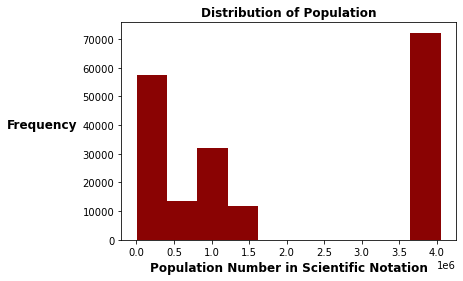

In [36]:
df_0['Population'].plot.hist(color = '#8a0303')
plt.title('Distribution of Population', fontweight = 'bold')
plt.ylabel('Frequency',fontweight = 'bold', rotation = 0,labelpad = 40,fontsize = 12)
plt.xlabel('Population Number in Scientific Notation', fontweight = 'bold',fontsize = 12)
plt.show()
#bimodal distribution
#skewed right w/outlier

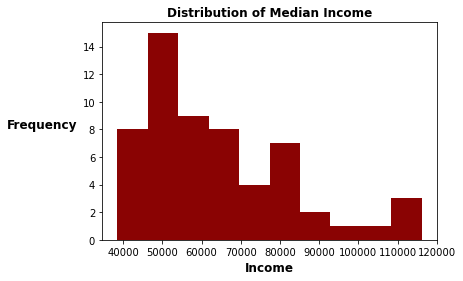

In [37]:
df_fips['median_income'].plot.hist(color = '#8a0303')
plt.title('Distribution of Median Income',fontweight = 'bold')
plt.ylabel('Frequency',fontweight = 'bold', rotation = 0,labelpad = 40,fontsize = 12)
plt.xlabel('Income',fontweight = 'bold',fontsize = 12)
plt.show()

We can see that our distribution for the Population is Bimodal or Skewed Right if we take out the outlier. We can also see that the outlier of the singular bar present on the far right, which is due to the high populations in dense regions like LA county or the Bay Area.

Then, for median income it follows a rather normal distribution without any flaring outliers.

## Data Visualizations

Using the county data set we utilized plotly to provide a heat map of the population density of California. The dark purple represents a greater population density according to the legend and we can see that the more dense parts are near the coast (Bay Area) and Southern California.


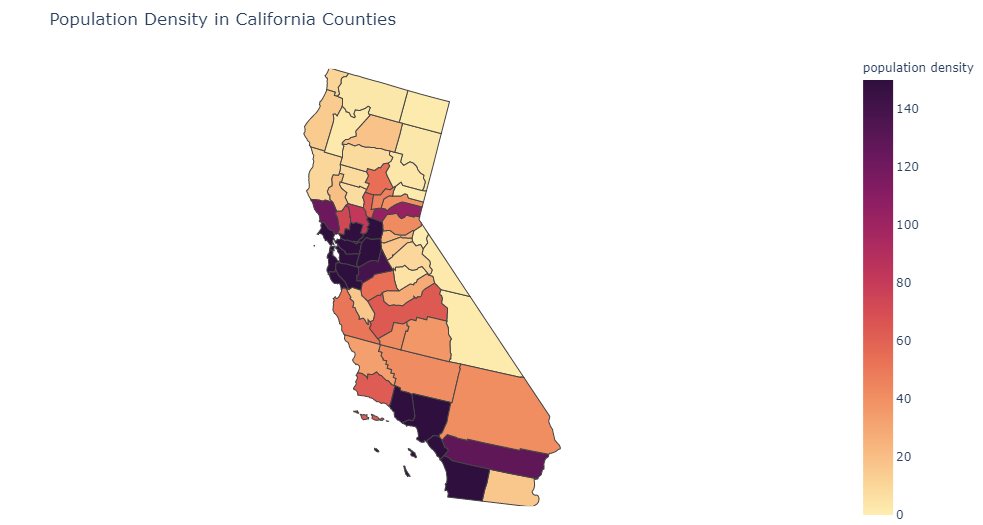

In [73]:
with open('./Data_Sets/county_polygrams.json') as response:
    counties = json.load(response)

fig = px.choropleth(df_fips, geojson=counties, locations='fips', title="tsadfdsfsdaf",color='population_density',
                           color_continuous_scale="matter",
                           range_color=(0, 150),
                           scope="usa",
                           labels={'population_density':'population density'}
                          )
fig.update_layout(title='Population Density in California Counties')
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=False)
#fig.show()
#Github does not let you show the figures on a python preview we have saved the maps as pngs in the repo
Image(filename='./images/popdens.png')

We can follow a similar procedure to visualize the median income using a heat map as well. Following a similar color scheme we can see that the Bay Area tends to have the highest median income compared to other counties in California. 

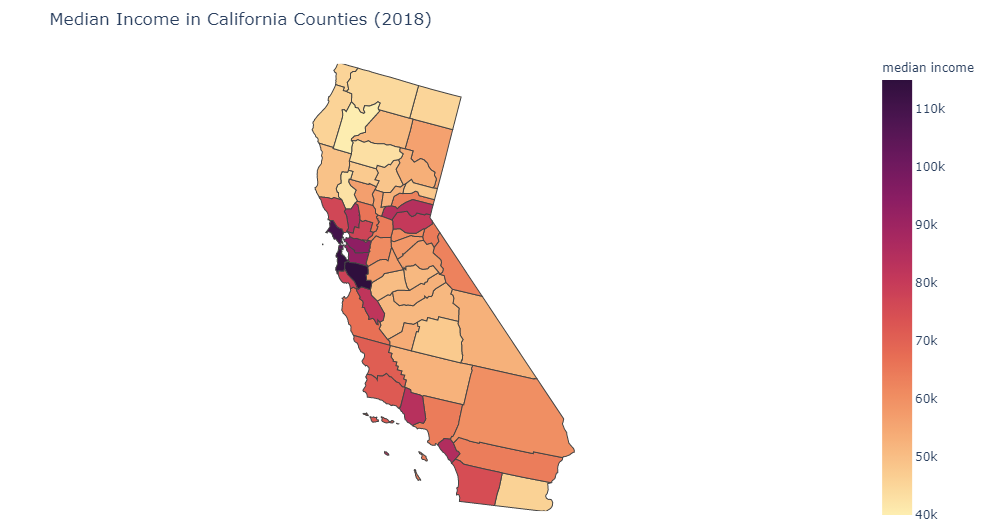

In [74]:
fig = px.choropleth(df_fips, geojson=counties, locations='fips', color='median_income',
                           color_continuous_scale="matter",
                           range_color=(40000, 115000),
                           scope="usa",
                           labels={'median_income':'median income'}
                          )
fig.update_layout(title='Median Income in California Counties (2018)')
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=False)

Image(filename='./images/medinc.png')

Lastly we want to visualize the percent success of Kickstarter projects and what regions of California have the closest percent success rate to 1. We can see that the highest percent success rate doesn't exactly correlate with our previous mappings as we see them more in land, however we can't let that cloud our hypothesis or analysis because we will have to delve deeper into the data. Since it is percent success this could mean there are counties with few projects but most of them succedeed hence a high success rate.

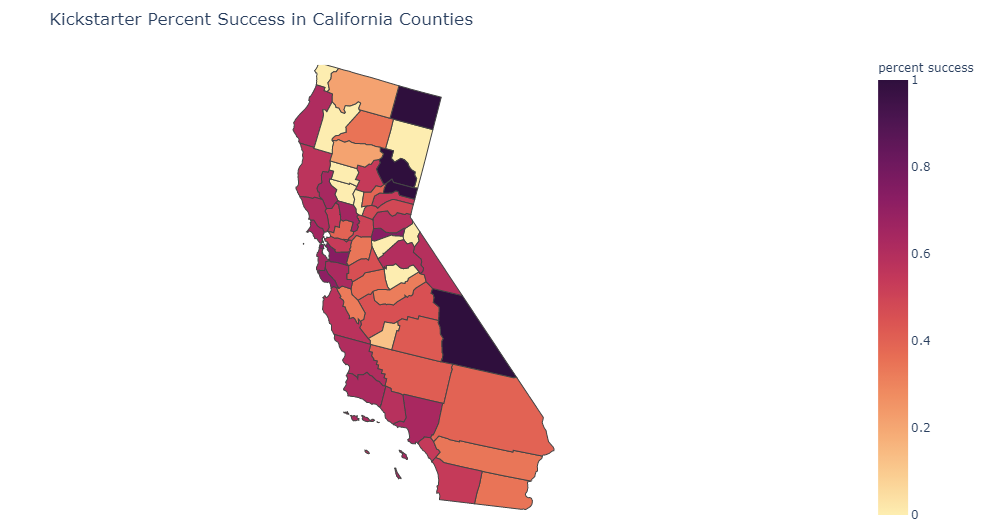

In [75]:
fig = px.choropleth(df_fips,geojson=counties,locations='fips', color='percent_success',
                           color_continuous_scale="matter",
                           range_color=(0, 1),
                           scope="usa",
                           labels={'percent_success':'percent success'}
                          )
fig.update_layout(title='Kickstarter Percent Success in California Counties')
fig.update_layout(margin={"r":0,"t":50,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=False)
Image(filename='./images/succrate.png')

Next we would like to visualize the 15 most common categories from which projects stem from, so we can use bar graph to help us.

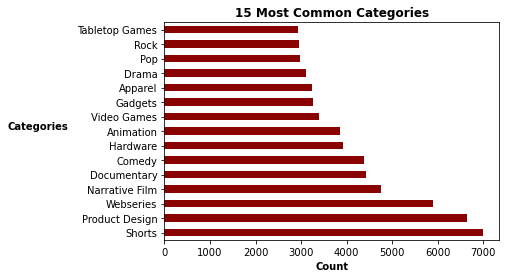

In [41]:
plt.title("15 Most Common Categories",fontweight = 'bold')
plt.ylabel("Categories",rotation= 0, labelpad = 40,fontweight = 'bold')
plt.xlabel("Count",fontweight = 'bold')
df_0['category'].value_counts().iloc[0:15].plot(kind='barh', color = '#8a0303')
plt.show()

Since there were around 150 categories this would be difficult to visualize all on a singular bar graph so we decided to split them up into most successful and least successful. We also got rid of the ones with less than 100 projects as that wouldn't give the best visualization as to which projects are truly successful.

In [42]:
df_temp = pd.DataFrame(df_0['category'].value_counts())
df_temp = df_temp.reset_index()


arrayOfGood = []
for index, row in df_temp.iterrows():
    arrayOfGood.append(df_0[df_0['category'] == row['index']]['boolean_status'].sum().astype(float))
df_temp['num_succ'] = arrayOfGood
df_temp['percent_succ'] = df_temp['num_succ'] / df_temp['category']
df_temp['category'] = df_temp[df_temp['category']> 100] 
df_temp.dropna(inplace=True)
df_temp = df_temp.sort_values(by=['percent_succ'],ascending=True)
df_temp = df_temp.reset_index()

Similarly, we can see what the 15 most unsucessful categories were for Kickstart projects

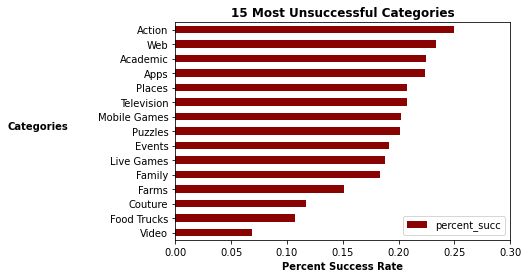

In [43]:
df_temp.iloc[0:15].plot(x = 'category',y = 'percent_succ', kind = 'barh',xlim = (0,0.3), color = '#8a0303')
plt.title("15 Most Unsuccessful Categories",fontweight = 'bold')
plt.ylabel("Categories", rotation = 0,labelpad = 60,fontweight= 'bold')
plt.xlabel("Percent Success Rate",fontweight = 'bold')
plt.show()

Now the 15 most successful categories for projects

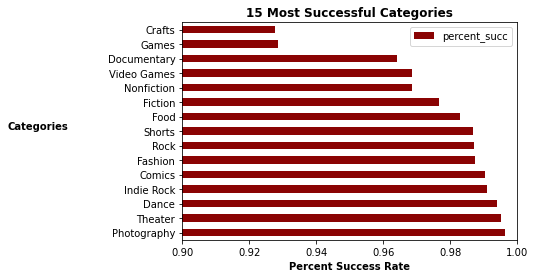

In [44]:
df_high = df_temp.sort_values(by=['percent_succ'],ascending=False)
df_high.iloc[0:15].plot(x = 'category', y = 'percent_succ', kind = 'barh', xlim=(0.9,1), color = '#8a0303')
plt.title("15 Most Successful Categories",fontweight = 'bold')
plt.ylabel("Categories",rotation = 0, labelpad = 70,fontweight = 'bold')
plt.xlabel("Percent Success Rate",fontweight = 'bold')
plt.show()

Wow, we should really make a photography project!

# Analysis

To model the features in the dataset, we first perform some preliminary steps to construct our modeling data.

In [45]:
df_1.head()

,county,median_income
0,Alameda,92574.0
1,Alpine,64688.0
2,Amador,61198.0
3,Butte,48443.0
4,Calaveras,58151.0


To ensure that we can add the `median_income` data to the corrosponding kickstarter data, we add ` County` to each county name in the dataframe.

In [46]:
df_1['county'] = df_1['county'] + " County"
print(df_1.head())
df_2.head()

             county  median_income
0    Alameda County        92574.0
1     Alpine County        64688.0
2     Amador County        61198.0
3      Butte County        48443.0
4  Calaveras County        58151.0


,index,county,state_name,population_density
0,186,Alameda County,California,860.757075
1,187,Alpine County,California,0.599281
2,188,Amador County,California,24.565345
3,189,Butte County,California,53.575159
4,190,Calaveras County,California,17.122606


To construct the modeling data, we take our `kickstarter` data and merge it with the `median_income` dataset and the `population_density` dataset.

In [47]:
modeling_data = df_0
print(modeling_data.shape)
modeling_data = modeling_data.merge(df_1, how = "left", on = "county")
modeling_data = modeling_data.merge(df_2, how = "left", on = "county")
print(modeling_data.shape)
modeling_data.head()

(187212, 10)
(187212, 14)


,backers_count,category,goal,pledged,goal_status,boolean_status,municipality,state_name_x,county,Population,median_income,index,state_name_y,population_density
0,335,Product Design,30000.0,83633.09,successful,True,Mountain View,CA,Santa Clara County,81527.0,116178.0,228,California,574.838370
1,10,Design,400.0,624.00,successful,True,San Francisco,CA,San Francisco County,883963.0,104552.0,223,California,7168.190471
2,483,Product Design,60000.0,64142.00,successful,True,Los Angeles,CA,Los Angeles County,4054400.0,64251.0,204,California,960.742778
3,42,Product Design,1000.0,2170.00,successful,True,San Diego,CA,San Diego County,1419845.0,74855.0,222,California,302.994150
4,588,Product Design,15000.0,31838.00,successful,True,Los Angeles,CA,Los Angeles County,4054400.0,64251.0,204,California,960.742778


As merging produces some duplicate columns, we select the desired columns and throw away the repeats.

In [48]:
modeling_data = modeling_data[["category","goal","county","Population","median_income","population_density","boolean_status"]]
modeling_data

,category,goal,county,Population,median_income,population_density,boolean_status
0,Product Design,30000.0,Santa Clara County,81527.0,116178.0,574.838370,True
1,Design,400.0,San Francisco County,883963.0,104552.0,7168.190471,True
2,Product Design,60000.0,Los Angeles County,4054400.0,64251.0,960.742778,True
3,Product Design,1000.0,San Diego County,1419845.0,74855.0,302.994150,True
4,Product Design,15000.0,Los Angeles County,4054400.0,64251.0,960.742778,True
...,...,...,...,...,...,...,...
187207,Product Design,45000.0,Orange County,276176.0,85398.0,1541.026670,True
187208,Nonfiction,500.0,San Francisco County,883963.0,104552.0,7168.190471,True
187209,Electronic Music,2000.0,Los Angeles County,4054400.0,64251.0,960.742778,False
187210,Print,50000.0,San Diego County,1419845.0,74855.0,302.994150,False


Before we start modeling the data, we compute some statistics to determine the correlation between some of our variables and whether a project succeeds or not. To compute correlation between a binary variable, success, and a continuous variable, we calculate the point biserial correlation coefficient using `scipy`.

In [49]:
stats.pointbiserialr(modeling_data["median_income"], modeling_data["boolean_status"])

PointbiserialrResult(correlation=0.08924992767813852, pvalue=0.0)

As we have a low p-value, we can see that there seems to be either no correlation or a weak positive correlation between `median_income` and whether a project succeeds.

In [50]:
stats.pointbiserialr(modeling_data["population_density"], modeling_data["boolean_status"])

PointbiserialrResult(correlation=0.11032793062141526, pvalue=0.0)

Similarly, we can see that there seems to be either no correlation or a weak positive correlation between `population_density` and whether a project succeeds. Both these findings for `median income` and `population_density` seem to be in line with our hypothesis that projects in areas with higher income and density would be more likely to succeed

In [51]:
stats.pointbiserialr(modeling_data["goal"], modeling_data["boolean_status"])

PointbiserialrResult(correlation=-0.04913221566327816, pvalue=2.096991821930958e-100)

On the other hand, there seems to be either no or a weak negative correlation between the amount of money a project is asking for and whether it succeeds

As our modeling data contains two categorical variables, we must first convert them to One-Hot encodings so they can be processed as features. We first process the listed `category` of each project

In [52]:
category_encoding = OneHotEncoder(handle_unknown='ignore')
category_encoding.fit(modeling_data['category'].to_numpy().reshape(-1, 1))
category_encoding.categories_

[array(['3D Printing', 'Academic', 'Accessories', 'Action', 'Animals',
        'Animation', 'Anthologies', 'Apparel', 'Apps', 'Architecture',
        'Art', 'Art Books', 'Audio', 'Bacon', 'Blues', 'Calendars',
        'Camera Equipment', 'Candles', 'Ceramics', 'Childrenswear',
        'Chiptune', 'Civic Design', 'Classical Music', 'Comedy',
        'Comic Books', 'Comics', 'Community Gardens', 'Conceptual Art',
        'Cookbooks', 'Couture', 'Crafts', 'Crochet', 'DIY',
        'DIY Electronics', 'Dance', 'Design', 'Digital Art', 'Documentary',
        'Drama', 'Drinks', 'Electronic Music', 'Embroidery', 'Events',
        'Experimental', 'Fabrication Tools', 'Faith', 'Family', 'Fantasy',
        'Farms', 'Fashion', 'Festivals', 'Fiction', 'Fine Art', 'Flight',
        'Food', 'Food Trucks', 'Footwear', 'Gadgets', 'Games',
        'Gaming Hardware', 'Glass', 'Graphic Design', 'Graphic Novels',
        'Hardware', 'Horror', 'Illustration', 'Immersive', 'Indie Rock',
        'Installation

In [53]:
category_one_hot = pd.DataFrame(category_encoding.transform(modeling_data["category"].to_numpy().reshape(-1, 1)).toarray())
category_one_hot.columns = category_encoding.get_feature_names()
modeling_data = modeling_data.join(category_one_hot)
modeling_data

,category,goal,county,Population,median_income,population_density,boolean_status,x0_3D Printing,x0_Academic,x0_Accessories,...,x0_Wearables,x0_Weaving,x0_Web,x0_Webcomics,x0_Webseries,x0_Woodworking,x0_Workshops,x0_World Music,x0_Young Adult,x0_Zines
0,Product Design,30000.0,Santa Clara County,81527.0,116178.0,574.838370,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Design,400.0,San Francisco County,883963.0,104552.0,7168.190471,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Product Design,60000.0,Los Angeles County,4054400.0,64251.0,960.742778,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Product Design,1000.0,San Diego County,1419845.0,74855.0,302.994150,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Product Design,15000.0,Los Angeles County,4054400.0,64251.0,960.742778,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187207,Product Design,45000.0,Orange County,276176.0,85398.0,1541.026670,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187208,Nonfiction,500.0,San Francisco County,883963.0,104552.0,7168.190471,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187209,Electronic Music,2000.0,Los Angeles County,4054400.0,64251.0,960.742778,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187210,Print,50000.0,San Diego County,1419845.0,74855.0,302.994150,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Before we built our full model, we first make some models that exclude our location data so we can compare the accuracies of each model later.

In [54]:
no_location = modeling_data.drop(["category","county","Population","median_income","population_density"], axis = 1)
no_location

,goal,boolean_status,x0_3D Printing,x0_Academic,x0_Accessories,x0_Action,x0_Animals,x0_Animation,x0_Anthologies,x0_Apparel,...,x0_Wearables,x0_Weaving,x0_Web,x0_Webcomics,x0_Webseries,x0_Woodworking,x0_Workshops,x0_World Music,x0_Young Adult,x0_Zines
0,30000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,400.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187207,45000.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187208,500.0,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187209,2000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187210,50000.0,False,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We split our data into the outcome variable, `boolean_status`, and the predictors.

In [55]:
outcomes = np.array(no_location["boolean_status"])
no_location.drop(["boolean_status"], axis = 1, inplace=True)
predictors = np.array(no_location)
print(outcomes)
print(predictors)

[ True  True  True ... False False False]
[[ 30000.      0.      0. ...      0.      0.      0.]
 [   400.      0.      0. ...      0.      0.      0.]
 [ 60000.      0.      0. ...      0.      0.      0.]
 ...
 [  2000.      0.      0. ...      0.      0.      0.]
 [ 50000.      0.      0. ...      0.      0.      0.]
 [150000.      0.      0. ...      0.      0.      0.]]


Next, we split our data into training and test data. As we have ~190,000 data points, a 90-10 split should provide sufficient testing data for the resulting model.

In [56]:
# specify training and test
num_training = int(len(modeling_data)*0.90)
num_testing = len(modeling_data)-num_training

print(num_training, num_testing)

train_X = predictors[:num_training]
train_Y = outcomes[:num_training]
test_X = predictors[num_training:]
test_Y = outcomes[num_training:]

168490 18722


First, we try two linear models and see how well they perform on the kickstarter data. Our first model is a perceptron, which trains faster than a model that uses stochastic gradient descent and produces a sparser model. Before inputing the data into the model, we standardize the features to ensure that our features are on similar scales.

In [57]:
perceptron = make_pipeline(StandardScaler(), Perceptron(tol=1e-3, random_state=0, verbose=True))
perceptron.fit(train_X, train_Y)

-- Epoch 1
Norm: 295.33, NNZs: 152, Bias: -39.000000, T: 168490, Avg. loss: 27.619892
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 300.94, NNZs: 152, Bias: -36.000000, T: 336980, Avg. loss: 27.500102
Total training time: 0.12 seconds.
-- Epoch 3
Norm: 295.53, NNZs: 152, Bias: -49.000000, T: 505470, Avg. loss: 27.634458
Total training time: 0.18 seconds.
-- Epoch 4
Norm: 270.57, NNZs: 152, Bias: -46.000000, T: 673960, Avg. loss: 27.677953
Total training time: 0.24 seconds.
-- Epoch 5
Norm: 284.06, NNZs: 152, Bias: -50.000000, T: 842450, Avg. loss: 27.609533
Total training time: 0.31 seconds.
-- Epoch 6
Norm: 260.71, NNZs: 152, Bias: -33.000000, T: 1010940, Avg. loss: 27.501844
Total training time: 0.37 seconds.
-- Epoch 7
Norm: 261.31, NNZs: 152, Bias: -39.000000, T: 1179430, Avg. loss: 27.661840
Total training time: 0.43 seconds.
Convergence after 7 epochs took 0.43 seconds


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('perceptron', Perceptron(verbose=True))])

In [58]:
predict_train = perceptron.predict(train_X)
print(classification_report(train_Y, predict_train))

              precision    recall  f1-score   support

       False       0.55      0.72      0.62     63394
        True       0.79      0.64      0.71    105096

    accuracy                           0.67    168490
   macro avg       0.67      0.68      0.67    168490
weighted avg       0.70      0.67      0.68    168490



In [59]:
predict_test = perceptron.predict(test_X)
print(classification_report(test_Y, predict_test))

              precision    recall  f1-score   support

       False       0.53      0.72      0.61      6861
        True       0.80      0.64      0.71     11861

    accuracy                           0.67     18722
   macro avg       0.67      0.68      0.66     18722
weighted avg       0.70      0.67      0.67     18722



While the precision percentages are around 80% for projects that succeeded, the precision for projects that failed is only 55%. The overall accuracy is roughly 67% for both the training set and the test set, indicating that while this model does better than guessing, it is unable to determine whether a project succeeds or failes with high accuracy.

Next, we try another linear classifier, stochastic gradient descent. This model requires a couple more hyperparameters which we keep at the default.

In [60]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, verbose = 1))
clf.fit(train_X, train_Y)

-- Epoch 1
Norm: 22.78, NNZs: 152, Bias: 0.793447, T: 168490, Avg. loss: 10.196156
Total training time: 0.06 seconds.
-- Epoch 2
Norm: 12.62, NNZs: 152, Bias: 0.562645, T: 336980, Avg. loss: 1.903870
Total training time: 0.13 seconds.
-- Epoch 3
Norm: 9.61, NNZs: 152, Bias: 0.583890, T: 505470, Avg. loss: 1.321228
Total training time: 0.20 seconds.
-- Epoch 4
Norm: 7.76, NNZs: 152, Bias: 0.567866, T: 673960, Avg. loss: 1.088213
Total training time: 0.26 seconds.
-- Epoch 5
Norm: 6.40, NNZs: 152, Bias: 0.515025, T: 842450, Avg. loss: 0.951231
Total training time: 0.33 seconds.
-- Epoch 6
Norm: 5.77, NNZs: 152, Bias: 0.168307, T: 1010940, Avg. loss: 0.867711
Total training time: 0.39 seconds.
-- Epoch 7
Norm: 5.04, NNZs: 152, Bias: 0.170972, T: 1179430, Avg. loss: 0.815429
Total training time: 0.45 seconds.
-- Epoch 8
Norm: 4.63, NNZs: 152, Bias: 0.325366, T: 1347920, Avg. loss: 0.774821
Total training time: 0.51 seconds.
-- Epoch 9
Norm: 4.19, NNZs: 152, Bias: 0.351644, T: 1516410, Avg.

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(verbose=1))])

In [61]:
predict_train = clf.predict(train_X)
print(classification_report(train_Y, predict_train))

              precision    recall  f1-score   support

       False       0.65      0.63      0.64     63394
        True       0.78      0.80      0.79    105096

    accuracy                           0.74    168490
   macro avg       0.72      0.72      0.72    168490
weighted avg       0.73      0.74      0.74    168490



In [62]:
predict_test = clf.predict(test_X)
print(classification_report(test_Y, predict_test))

              precision    recall  f1-score   support

       False       0.65      0.64      0.65      6861
        True       0.79      0.80      0.80     11861

    accuracy                           0.74     18722
   macro avg       0.72      0.72      0.72     18722
weighted avg       0.74      0.74      0.74     18722



This model performs noticebly better on both the training data as well as the test data, but still has trouble predicting projects that fail compared to projects that succeed.

Next, we built a more complex model called a multi-layer perceptron classifier. This model builts a neural network out of perceptrons, allowing it to model non-linear functions. Similarly to the previous models, we standardize the features to ensure that the model trains faster.

In [63]:
neural_net = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, max_iter=1000, verbose=True))
neural_net.fit(train_X, train_Y)

Iteration 1, loss = 0.50583949
Iteration 2, loss = 0.49400881
Iteration 3, loss = 0.49207494
Iteration 4, loss = 0.49077758
Iteration 5, loss = 0.48964174
Iteration 6, loss = 0.48879317
Iteration 7, loss = 0.48805254
Iteration 8, loss = 0.48765964
Iteration 9, loss = 0.48734430
Iteration 10, loss = 0.48671608
Iteration 11, loss = 0.48613769
Iteration 12, loss = 0.48574770
Iteration 13, loss = 0.48524159
Iteration 14, loss = 0.48482482
Iteration 15, loss = 0.48466997
Iteration 16, loss = 0.48387449
Iteration 17, loss = 0.48365703
Iteration 18, loss = 0.48333627
Iteration 19, loss = 0.48303020
Iteration 20, loss = 0.48267200
Iteration 21, loss = 0.48251290
Iteration 22, loss = 0.48230108
Iteration 23, loss = 0.48195363
Iteration 24, loss = 0.48154459
Iteration 25, loss = 0.48147657
Iteration 26, loss = 0.48122730
Iteration 27, loss = 0.48115790
Iteration 28, loss = 0.48064403
Iteration 29, loss = 0.48067419
Iteration 30, loss = 0.48040655
Iteration 31, loss = 0.48020515
Iteration 32, los

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=1000, random_state=1, verbose=True))])

After training, we can visualize the loss curve of the model compared to the number of iterations.

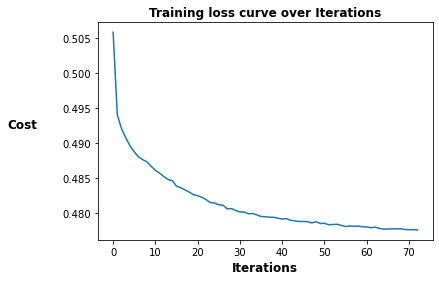

In [64]:
plt.title('Training loss curve over Iterations', fontweight = 'bold')
plt.ylabel('Cost',fontweight = 'bold', rotation = 0,labelpad = 40,fontsize = 12)
plt.xlabel('Iterations', fontweight = 'bold',fontsize = 12)

plt.plot(neural_net[1].loss_curve_)
plt.show()

In [65]:
predict_train = neural_net.predict(train_X)
print(classification_report(train_Y, predict_train))

              precision    recall  f1-score   support

       False       0.67      0.64      0.66     63394
        True       0.79      0.81      0.80    105096

    accuracy                           0.75    168490
   macro avg       0.73      0.73      0.73    168490
weighted avg       0.75      0.75      0.75    168490



In [66]:
predict_test = neural_net.predict(test_X)
print(classification_report(test_Y, predict_test))

              precision    recall  f1-score   support

       False       0.67      0.65      0.66      6861
        True       0.80      0.81      0.81     11861

    accuracy                           0.75     18722
   macro avg       0.73      0.73      0.73     18722
weighted avg       0.75      0.75      0.75     18722



While this model performs better than the single perceptron model, it only performs slightly better than the stochastic gradient descent model. However, this model runs into the similar problem that projects that fail are harder to predict than projects that succeed. Overall, the MLP classifier is able to predict the success of a kickstarter project with some degree of accurary, as it has an accuracy of roughly 75%.

Next, we create a One Hot encoding for the county that each kickstarter project is in.

In [67]:
county_encoding = OneHotEncoder(handle_unknown='ignore')
county_encoding.fit(df_1['county'].to_numpy().reshape(-1, 1))
county_encoding.categories_

[array(['Alameda County', 'Alpine County', 'Amador County', 'Butte County',
        'Calaveras County', 'Colusa County', 'Contra Costa County',
        'Del Norte County', 'El Dorado County', 'Fresno County',
        'Glenn County', 'Humboldt County', 'Imperial County',
        'Inyo County', 'Kern County', 'Kings County', 'Lake County',
        'Lassen County', 'Los Angeles County', 'Madera County',
        'Marin County', 'Mariposa County', 'Mendocino County',
        'Merced County', 'Modoc County', 'Mono County', 'Monterey County',
        'Napa County', 'Nevada County', 'Orange County', 'Placer County',
        'Plumas County', 'Riverside County', 'Sacramento County',
        'San Benito County', 'San Bernardino County', 'San Diego County',
        'San Francisco County', 'San Joaquin County',
        'San Luis Obispo County', 'San Mateo County',
        'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
        'Shasta County', 'Sierra County', 'Siskiyou County',


In [68]:
county_one_hot = pd.DataFrame(county_encoding.transform(modeling_data["county"].to_numpy().reshape(-1, 1)).toarray())
county_one_hot.columns = county_encoding.get_feature_names()
modeling_data = modeling_data.join(county_one_hot)
modeling_data

,category,goal,county,Population,median_income,population_density,boolean_status,x0_3D Printing,x0_Academic,x0_Accessories,...,x0_Sonoma County,x0_Stanislaus County,x0_Sutter County,x0_Tehama County,x0_Trinity County,x0_Tulare County,x0_Tuolumne County,x0_Ventura County,x0_Yolo County,x0_Yuba County
0,Product Design,30000.0,Santa Clara County,81527.0,116178.0,574.838370,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Design,400.0,San Francisco County,883963.0,104552.0,7168.190471,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Product Design,60000.0,Los Angeles County,4054400.0,64251.0,960.742778,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Product Design,1000.0,San Diego County,1419845.0,74855.0,302.994150,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Product Design,15000.0,Los Angeles County,4054400.0,64251.0,960.742778,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187207,Product Design,45000.0,Orange County,276176.0,85398.0,1541.026670,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187208,Nonfiction,500.0,San Francisco County,883963.0,104552.0,7168.190471,True,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187209,Electronic Music,2000.0,Los Angeles County,4054400.0,64251.0,960.742778,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187210,Print,50000.0,San Diego County,1419845.0,74855.0,302.994150,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We drop the duplicate columns that are now one-hot encoded before proceeding.

In [69]:
modeling_data.drop(["category","county"], axis = 1, inplace=True)
modeling_data

,goal,Population,median_income,population_density,boolean_status,x0_3D Printing,x0_Academic,x0_Accessories,x0_Action,x0_Animals,...,x0_Sonoma County,x0_Stanislaus County,x0_Sutter County,x0_Tehama County,x0_Trinity County,x0_Tulare County,x0_Tuolumne County,x0_Ventura County,x0_Yolo County,x0_Yuba County
0,30000.0,81527.0,116178.0,574.838370,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,400.0,883963.0,104552.0,7168.190471,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60000.0,4054400.0,64251.0,960.742778,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000.0,1419845.0,74855.0,302.994150,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15000.0,4054400.0,64251.0,960.742778,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187207,45000.0,276176.0,85398.0,1541.026670,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187208,500.0,883963.0,104552.0,7168.190471,True,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187209,2000.0,4054400.0,64251.0,960.742778,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
187210,50000.0,1419845.0,74855.0,302.994150,False,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Similar to before, we split the data into outcomes and predictors. Then we further split the data into training data and testing data with a 90-10 split.

In [70]:
outcomes = np.array(modeling_data["boolean_status"])
modeling_data.drop(["boolean_status"], axis = 1, inplace=True)
predictors = np.array(modeling_data)
print(outcomes)
print(predictors)

[ True  True  True ... False False False]
[[3.000000e+04 8.152700e+04 1.161780e+05 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [4.000000e+02 8.839630e+05 1.045520e+05 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [6.000000e+04 4.054400e+06 6.425100e+04 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [2.000000e+03 4.054400e+06 6.425100e+04 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [5.000000e+04 1.419845e+06 7.485500e+04 ... 0.000000e+00 0.000000e+00
  0.000000e+00]
 [1.500000e+05 4.054400e+06 6.425100e+04 ... 0.000000e+00 0.000000e+00
  0.000000e+00]]


In [71]:
# specify training and test
num_training = int(len(modeling_data)*0.90)
num_testing = len(modeling_data)-num_training

print(num_training, num_testing)

168490 18722


In [72]:
train_X = predictors[:num_training]
train_Y = outcomes[:num_training]
test_X = predictors[num_training:]
test_Y = outcomes[num_training:]

We first train another perceptron classifier, except now we include the location data with the kickstarter data.

In [73]:
perceptron = make_pipeline(StandardScaler(), Perceptron(tol=1e-3, random_state=0, verbose=True))
perceptron.fit(train_X, train_Y)

-- Epoch 1
Norm: 493.26, NNZs: 206, Bias: 28.000000, T: 168490, Avg. loss: 34.727837
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 477.98, NNZs: 206, Bias: -1.000000, T: 336980, Avg. loss: 35.155951
Total training time: 0.14 seconds.
-- Epoch 3
Norm: 458.41, NNZs: 206, Bias: 21.000000, T: 505470, Avg. loss: 34.979514
Total training time: 0.22 seconds.
-- Epoch 4
Norm: 519.64, NNZs: 206, Bias: 18.000000, T: 673960, Avg. loss: 34.866465
Total training time: 0.30 seconds.
-- Epoch 5
Norm: 530.18, NNZs: 206, Bias: 12.000000, T: 842450, Avg. loss: 35.070559
Total training time: 0.38 seconds.
-- Epoch 6
Norm: 508.87, NNZs: 206, Bias: 31.000000, T: 1010940, Avg. loss: 35.010005
Total training time: 0.46 seconds.
Convergence after 6 epochs took 0.46 seconds


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('perceptron', Perceptron(verbose=True))])

In [74]:
predict_train = perceptron.predict(train_X)
print(classification_report(train_Y, predict_train))

              precision    recall  f1-score   support

       False       0.59      0.59      0.59     63394
        True       0.75      0.76      0.75    105096

    accuracy                           0.69    168490
   macro avg       0.67      0.67      0.67    168490
weighted avg       0.69      0.69      0.69    168490



In [75]:
predict_test = perceptron.predict(test_X)
print(classification_report(test_Y, predict_test))

              precision    recall  f1-score   support

       False       0.58      0.60      0.59      6861
        True       0.76      0.75      0.76     11861

    accuracy                           0.70     18722
   macro avg       0.67      0.67      0.67     18722
weighted avg       0.70      0.70      0.70     18722



Compared to the other perceptron model which doesn't include location data, this model has a slightly higher accuracy (67% compared to 70%). If a given project succeeds, the model is able to predict its success with a 76% accuracy.

Next, we train another stochastic gradient descent classifier with the location data.

In [76]:
clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3, verbose = 1))
clf.fit(train_X, train_Y)

-- Epoch 1
Norm: 28.21, NNZs: 206, Bias: 0.072859, T: 168490, Avg. loss: 10.537580
Total training time: 0.07 seconds.
-- Epoch 2
Norm: 15.50, NNZs: 206, Bias: 1.186611, T: 336980, Avg. loss: 1.977198
Total training time: 0.14 seconds.
-- Epoch 3
Norm: 11.88, NNZs: 206, Bias: 0.381859, T: 505470, Avg. loss: 1.362566
Total training time: 0.22 seconds.
-- Epoch 4
Norm: 9.28, NNZs: 206, Bias: 0.843920, T: 673960, Avg. loss: 1.124595
Total training time: 0.29 seconds.
-- Epoch 5
Norm: 8.14, NNZs: 206, Bias: 0.859245, T: 842450, Avg. loss: 0.987812
Total training time: 0.37 seconds.
-- Epoch 6
Norm: 7.10, NNZs: 206, Bias: 0.529721, T: 1010940, Avg. loss: 0.905960
Total training time: 0.45 seconds.
-- Epoch 7
Norm: 6.63, NNZs: 206, Bias: 0.645011, T: 1179430, Avg. loss: 0.843239
Total training time: 0.53 seconds.
-- Epoch 8
Norm: 6.11, NNZs: 206, Bias: 0.595410, T: 1347920, Avg. loss: 0.808842
Total training time: 0.61 seconds.
-- Epoch 9
Norm: 5.80, NNZs: 206, Bias: 0.600585, T: 1516410, Avg

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('sgdclassifier', SGDClassifier(verbose=1))])

In [77]:
predict_train = clf.predict(train_X)
print(classification_report(train_Y, predict_train))

              precision    recall  f1-score   support

       False       0.65      0.66      0.66     63394
        True       0.80      0.79      0.79    105096

    accuracy                           0.74    168490
   macro avg       0.72      0.73      0.73    168490
weighted avg       0.74      0.74      0.74    168490



In [78]:
predict_test = clf.predict(test_X)
print(classification_report(test_Y, predict_test))

              precision    recall  f1-score   support

       False       0.65      0.66      0.65      6861
        True       0.80      0.79      0.80     11861

    accuracy                           0.74     18722
   macro avg       0.72      0.73      0.73     18722
weighted avg       0.75      0.74      0.74     18722



Compared to the SGDClassifier without location data, this model performs roughly the same and achieves a 74% accuracy on the test data.

Next, we train another multi-layer perceptron classifier on the kickstarter data.

In [79]:
neural_net = make_pipeline(StandardScaler(), MLPClassifier(random_state=1, max_iter=1000, verbose=True))
neural_net.fit(train_X, train_Y)

Iteration 1, loss = 0.48383510
Iteration 2, loss = 0.45805429
Iteration 3, loss = 0.44939905
Iteration 4, loss = 0.44359238
Iteration 5, loss = 0.43923133
Iteration 6, loss = 0.43637513
Iteration 7, loss = 0.43373256
Iteration 8, loss = 0.43201005
Iteration 9, loss = 0.43014524
Iteration 10, loss = 0.42976153
Iteration 11, loss = 0.42785334
Iteration 12, loss = 0.42727466
Iteration 13, loss = 0.42626178
Iteration 14, loss = 0.42549337
Iteration 15, loss = 0.42478817
Iteration 16, loss = 0.42401173
Iteration 17, loss = 0.42353330
Iteration 18, loss = 0.42313121
Iteration 19, loss = 0.42242840
Iteration 20, loss = 0.42188713
Iteration 21, loss = 0.42178187
Iteration 22, loss = 0.42111699
Iteration 23, loss = 0.42060191
Iteration 24, loss = 0.42058772
Iteration 25, loss = 0.41983037
Iteration 26, loss = 0.41939828
Iteration 27, loss = 0.41927292
Iteration 28, loss = 0.41908832
Iteration 29, loss = 0.41876491
Iteration 30, loss = 0.41845941
Iteration 31, loss = 0.41833703
Iteration 32, los

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(max_iter=1000, random_state=1, verbose=True))])

After training, we can visualize the loss curve of the model compared to the number of iterations.

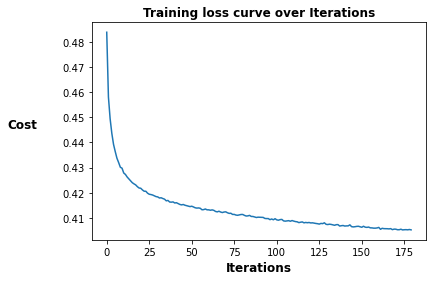

In [80]:
plt.title('Training loss curve over Iterations', fontweight = 'bold')
plt.ylabel('Cost',fontweight = 'bold', rotation = 0,labelpad = 40,fontsize = 12)
plt.xlabel('Iterations', fontweight = 'bold',fontsize = 12)
plt.plot(neural_net[1].loss_curve_)
plt.show()

This graphs shows us that the model is improving as expected, as the cost of the model quicky decreases then gradually levels off.

In [81]:
predict_train = neural_net.predict(train_X)
print(classification_report(train_Y, predict_train))

              precision    recall  f1-score   support

       False       0.75      0.70      0.72     63394
        True       0.82      0.86      0.84    105096

    accuracy                           0.80    168490
   macro avg       0.79      0.78      0.78    168490
weighted avg       0.80      0.80      0.80    168490



In [82]:
predict_test = neural_net.predict(test_X)
print(classification_report(test_Y, predict_test))

              precision    recall  f1-score   support

       False       0.74      0.70      0.72      6861
        True       0.83      0.86      0.84     11861

    accuracy                           0.80     18722
   macro avg       0.79      0.78      0.78     18722
weighted avg       0.80      0.80      0.80     18722



Compared to the other models, this model performs the best on both the training data and the test data. While the MLP classifier without the location data achieved an accuracy of ~75%, this MLP classifier is able to predict the success of a kickstarter project with 80% accuracy. For kickstarter projects that ultimately succeed, the model is able to predict their success with 84% accuracy. On the other hand, the model performs worse on projects that fail, as it only has a precision of 72% for projects that fail.

# Ethics & Privacy

$Addressing \; Potential \; Bias$
 
Though our analysis aims to measure the success rates of Kickstarter projects at the county level, it is important to recognize some of the unintended consequences and assumptions that can be drawn from our results. Our original question posses if whether median income and population density are factors to a project's success. Something that can be further explored is the correlations inadvertently tracked by by our analysis. For example, could these differences be also attributed to Income disparities based on race and income class (lower, middle, and upper class)? For example, a publishing carried out by the Public Policy Institute of California found that,
    
<blockquote>
"[The] polarization of incomes in California: top incomes are
more than eight times the size of bottom incomes. We have also shown that income inequality
is about 40 percent higher before we take account of resources from cash, nutrition, housing,
and tax programs that assist families in the lower part of the economic spectrum"$^{[1]}$ (Bohn,Danielson 17).
</blockquote>
 
We understand how these factors maybe be inadvertently tracked in our data and recognized that being able to carry out an analysis based on these factors require a very specific and nuanced understanding of these issues.   
 
$Ethics \; of \; our \; Data$
 
For our data, we decided to specifically examine Kickstarter data from 2018 because the most up to date U.S. census data based on county was last published in 2018. We made this decision in order to ensure that we did not have any chronological bias in our analysis of the kickstarter data i.e. using 2018 population and income data to predict Kickstarter success rate in 2019 and 2020. To combine our datasets, we chose to do so by mapping the county column of each dataframe. This allowed us to carry out our analysis on the county level as well as plot our data visually. 
    
$Permissions$:
 
All the data is publicly available for free of use. These data follow the terms of service agreements in which the data will not contribute any Content or User Submission that:
- Violates the Acceptable Use Policy
- Is harmful, threatening, harassing, defamatory, obscene, or otherwise objectionable;
- “Crawls,” “scrapes,” or “spiders” any page, data or portion of or relating to Services or Content
- Copies or stores any significant portion of the Content;
- Decompiles, reverse engineers, or otherwise attempts to obtain the source code or underlying ideas or information of relating to the Services
- Processes or stores any data that is subject to the International Traffic in Arms Regulations maintained by the U.S. Department of State
 
The information from which the data was collected on the Kickstarter page also follows the Terms and Conditions of Kickstarter, which has a detailed description of the Terms of Use and how the privacy of the information and intellectual property is secured. Further, Kickstarter will only approve projects that are ethically acceptable to be promoted by the website. 
 
$Privacy$
 
During the data cleaning process, we identified datasets that require further cleaning in order to ensure the anonymization of all our data. (removing personally identifiable information from dataset PII)
The Kickstart dataset was the only dataset with any personally identifiable information (PII) such as URLs to the listing and websites, project names, company names, and username. We made sure to remove all that information which was highlighted in the data cleaning portion of `df_0`. 
 
$[1]$: https://www.ppic.org/content/pubs/report/R_516SBR.pdf


# Conclusion & Discussion

Originally, we asked whether we could find a relationship between the success rate of a Kickstarter project and its characteristics, such as genre and geographical location. Using a dataset of Kickstarter projects as well as other assisting datasets with geographical data, we were able to map additional information to each project using the city that the project was based in.

Looking at the distributions of median income and population density in California, we first observed that counties with higher incomes and density tended to have a higher proportion of successes. Furthermore, different genres of projects have very different success rates, with projects tagged as `video` having a success rate under 10% while `photography` projects have a success rate above 99%. However, statistical tests revealed that features such as median income and population density are only weakly correlated with success rate. Therefore, these factors could have some impact on success rate, but are unable to model whether a project succeeds or fails with notable accuracy.

Next, we tried to predict the success of a project with and without additional geographic parameters. While the linear models performed roughly the same, achieving a maximum accuracy of 75%, our multilevel perception classifier was able to achieve an accuracy of 80% with geographical parameters, as opposed to 75% without. 

However, our analysis has many limitations. As we only focused on California, its possible that our conclusions don't generalize to the entire country. Additionally, we were unable to find suitable data to analyze on a city level, so our county level analysis could be missing details that would impact our conclusions. It is also possible that the non-linear models we used did not achieve the maximum accuracy, as we did not perform hyper-parameter tuning and instead used the default values. Even so, our analysis reveals that the success of a Kickstarter project can be predicted to some degree of accuracy, which could be helpful data for those thinking of starting a project or individuals looking to invest in promising ideas.

# Team Contributions

**Joshua Hong**
* Worked on data cleaning for the secondary datasets as well as the county merging for the Kickstarter dataset
* Built classification models as well as point-biserial correlation calculations
* Contributed to background research and found related analyses
* Wrote conclusion section and datasets section
* Investigated and selected appropriate datasets needed for analysis

**Luke Sirand**
* Organized the Kickstarter data so it could be read as a dataframe
* Setup section for datasets
* Data cleaning for Kickstarter data
* Wrote datasets section for Kickstarter data
* Df pickling for more efficient workflow
* Ethics and Privacy section
* Researched Datasets

**Jae Lee**
* Background, Question, and Hypothesis formulation
* Wrote Permissions Section 
* Quality Assurance
* Video Coordinator

**Ronak Vyas**
* Worked on creating county dataset and gathering polygons for Maps
* Setup dataframe to connect counties to other datasets (ie. Median Income/Population)
* Assisted EDA writeup
* Data cleaned geo pandas json to fit California

**Gaurav Mehta**
* EDA work, analyzed distribution of variables and outliers
* Created bar graph visualizations 
* Cleaned up dataframes for visualizations
* EDA Writeup
* Commented code
* Fixed visualizations to make them easy to view and understand for the user
